<a href="https://colab.research.google.com/github/itzrnvr/opencv-labs/blob/main/lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar100
import cv2

In [2]:
DATA_LOCATION = "keras.datasets.cifar100"

In [3]:
def fetch_data():
    train, test = cifar100.load_data()
    xtr, _ = train
    xte, _ = test
    xtr = xtr.astype(np.float32) / 255.0
    xte = xte.astype(np.float32) / 255.0
    return xtr, xte

In [4]:
def inject_noise(arr, t='gaussian'):
    out = arr.copy()
    if t == 'gaussian':
        out = out + np.random.normal(0, 0.1, out.shape)
    elif t == 'salt_pepper':
        px = 0.02
        out = np.copy(arr)
        b, w = 0, 1
        for idx in range(arr.shape[0]):
            msk = np.random.choice([b, w, -1], size=arr[idx].shape, p=[px/2, px/2, 1-px])
            out[idx][msk == b] = 0
            out[idx][msk == w] = 1
    return np.clip(out, 0, 1)

In [5]:
def make_autoencoder():
    i = layers.Input(shape=(32, 32, 3))
    h1 = layers.Conv2D(32, 3, activation='relu', padding='same')(i)
    h2 = layers.MaxPool2D(2, padding='same')(h1)
    h3 = layers.Conv2D(64, 3, activation='relu', padding='same')(h2)
    h4 = layers.MaxPool2D(2, padding='same')(h3)
    code = layers.Conv2D(128, 3, activation='relu', padding='same')(h4)
    d1 = layers.Conv2D(128, 3, activation='relu', padding='same')(code)
    d2 = layers.UpSampling2D(2)(d1)
    d3 = layers.Conv2D(64, 3, activation='relu', padding='same')(d2)
    d4 = layers.UpSampling2D(2)(d3)
    out = layers.Conv2D(3, 3, activation='sigmoid', padding='same')(d4)
    model = models.Model(i, out)
    model.compile(optimizer='adam', loss='mse')
    return model

In [6]:
def fit_model(model, x_noise, x_clean, x_noise_val, x_val):
    model.fit(x_noise, x_clean, epochs=5, batch_size=64, shuffle=True, validation_data=(x_noise_val, x_val))

In [7]:
def visualize_restoration(model, noisy, gt):
    output = model.predict(noisy[:10])
    fig, axes = plt.subplots(3, 10, figsize=(15, 5))
    for idx in range(10):
        axes[0, idx].imshow(gt[idx])
        axes[1, idx].imshow(noisy[idx])
        axes[2, idx].imshow(output[idx])
        axes[0, idx].axis('off')
        axes[1, idx].axis('off')
        axes[2, idx].axis('off')
    plt.show()

In [8]:
def pipeline():
    trn, tst = fetch_data()
    trn_noisy, tst_noisy = inject_noise(trn), inject_noise(tst)
    ae = make_autoencoder()
    fit_model(ae, trn_noisy, trn, tst_noisy, tst)
    visualize_restoration(ae, tst_noisy, tst)

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 462s 587ms/step - loss: 0.0147 - val_loss: 0.0050
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 443s 566ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 500s 563ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 462s 590ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 505s 594ms/step - loss: 0.0034 - val_loss: 0.0033
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


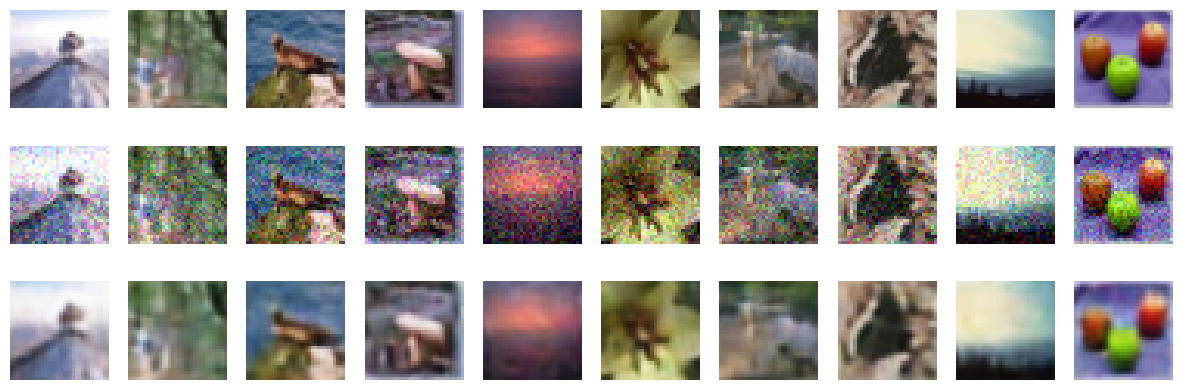

In [9]:
if __name__ == "__main__":
    pipeline()